# **ENSAMBLE CNN Y LSTM PARA PREDICCIÓN DE LOS CASOS DE DENGUE**

## **Importaciones y Configuración**

En esta primera etapa, nos enfocamos en establecer las condiciones iniciales del experimento para garantizar la reproducibilidad de los resultados. Para ello, fijamos todas las semillas aleatorias (SEED = 42), incluyendo las correspondientes a numpy, random y tensorflow.

También definimos las constantes clave a partir de los hallazgos obtenidos en el análisis exploratorio de datos (EDA). La variable AÑOS_A_EXCLUIR agrupa los años correspondientes al “valle” en la serie temporal, los cuales decidimos filtrar para evitar sesgos en el entrenamiento que dificultaban la correcta identificación de los picos epidemiológicos. Por otro lado, establecimos LOOK_BACK = 12 como ventana de tiempo, ya que este valor fue el que mostró mejores resultados en nuestras pruebas preliminares para capturar patrones relevantes en la serie. Esta elección también se sustenta en los hallazgos presentados en el EDA.

In [ ]:
# --- Celda 1: Importaciones y Configuración ---
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from datetime import datetime
import matplotlib.pyplot as plt

# 1.1. FIJAR SEMILLAS
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1.2. CONFIGURACIÓN
PATH_TRAIN = '../../Datos/df_train.parquet'
PATH_TEST = '../../Datos/df_test.parquet'
AÑO_VALIDACION = 2021
LOOK_BACK_GANADOR = 12
EPOCHS = 40
AÑOS_A_EXCLUIR = [2017, 2018, 2019] # <-- NUEVO: Años de baja incidencia a filtrar

tf.keras.backend.clear_session()
print("Configuración lista para el modelo 'El Conquistador de Picos'.")

2025-06-29 12:38:36.195478: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 12:38:36.374400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 12:38:36.374443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 12:38:36.406969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 12:38:36.457826: I tensorflow/core/platform/cpu_feature_guar

Configuración lista para el modelo 'El Conquistador de Picos'.


## **Carga de Datos**

En esta etapa, cargamos los datos crudos desde archivos en formato Parquet. Decidimos encapsular este proceso en una función y estandarizar los nombres de las columnas a minúsculas, como una buena práctica de limpieza y organización del código. Esta estrategia no solo mejora la legibilidad, sino que también ayuda a prevenir errores futuros relacionados con inconsistencias en los nombres de las variables.

In [2]:
# --- Celda 2: Carga de Datos ---
def load_data(path_train, path_test):
    df_train = pd.read_parquet(path_train)
    df_test = pd.read_parquet(path_test)
    for df in [df_train, df_test]: 
        df.columns = [col.lower() for col in df.columns]
    return df_train, df_test

print("Cargando datos...")
df_train_raw, df_test_original = load_data(PATH_TRAIN, PATH_TEST)
print("Datos cargados.")

Cargando datos...
Datos cargados.


## **Feature Engineering**

Esta es una de las celdas más relevantes del experimento, ya que implementamos aquí nuestra estrategia de procesamiento de datos más robusta, directamente derivada de los hallazgos del EDA.

* **Filtrado de años anómalos:** Excluimos los años 2017, 2018 y 2019 del conjunto de entrenamiento, con base en lo evidenciado en la gráfica del “valle” del EDA. Estos años presentaron un comportamiento atípico, con una baja incidencia de casos, lo cual inducía al modelo a generar predicciones excesivamente conservadoras. Al removerlos, buscamos forzar al modelo a aprender patrones asociados a años con presencia real de epidemias.

* **Transformación logarítmica:** Aplicamos np.log1p() sobre la variable objetivo (dengue), debido al alto sesgo positivo observado en su distribución (Gráfica 2 del EDA). Esta transformación ayuda a normalizar la variable, facilitando que el modelo aprenda mejor la dinámica de los picos sin ser penalizado de forma desproporcionada por la función de pérdida (MSE).

* **Incorporación de rezagos climáticos:** Finalmente, generamos variables rezagadas de los indicadores climáticos. Las gráficas 4 y 5 del EDA mostraron una fuerte correlación entre estas variables y la ocurrencia de casos de dengue, por lo que su inclusión como variables predictoras resulta fundamental para mejorar el desempeño del modelo.

In [3]:
# --- Celda 3: Feature Engineering ---
def create_features_and_transform(df_train, df_test, max_lag, exclude_years):
    weather_cols = ['lluvia_mean', 'temperatura_mean']
    df_test['dengue'] = np.nan
    df_full = pd.concat([df_train, df_test], ignore_index=True)
    df_full = df_full.sort_values(by=['id_bar', 'anio', 'semana']).reset_index(drop=True)

    # Crear rezagos
    for col in weather_cols:
        for i in range(1, max_lag + 1):
            df_full[f'{col}_lag_{i}'] = df_full.groupby('id_bar')[col].shift(i)
    
    # 1. Filtrar los años de baja incidencia (solo del set de entrenamiento)
    is_train = df_full['anio'] < 2022
    is_excluded_year = df_full['anio'].isin(exclude_years)
    # Mantener todas las filas que no son de entrenamiento O que no son de años excluidos
    df_filtered = df_full[~is_train | ~is_excluded_year].copy()
    
    # 2. Aplicar transformación logarítmica a la variable objetivo
    df_filtered['dengue_log'] = np.log1p(df_filtered['dengue'])
    
    df_filtered.fillna(0, inplace=True)
    return df_filtered

print("Aplicando filtrado de años y transformación logarítmica...")
df_transformed = create_features_and_transform(df_train_raw.copy(), df_test_original.copy(), LOOK_BACK_GANADOR, AÑOS_A_EXCLUIR)
print("Feature Engineering completado.")

Aplicando filtrado de años y transformación logarítmica...
Feature Engineering completado.


## **Definición de Arquitecturas**

Después de probar distintas arquitecturas de modelos secuenciales, como RNN, GRU, TCN y combinaciones en ensamble, optamos por implementar una arquitectura CNN-LSTM debido a su solidez y buen desempeño en nuestras pruebas. La combinación de estas dos capas nos permite aprovechar lo mejor de ambos enfoques: la CNN captura patrones locales en la secuencia temporal, mientras que la LSTM es capaz de modelar dependencias a largo plazo. Esta arquitectura ha demostrado ser robusta para el tipo de serie que estamos analizando, por lo que la seleccionamos como base para la siguiente fase del modelado.

In [4]:
# --- Celda 4: Definición de Arquitectura ---
def build_champion_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

print("Arquitectura campeona (CNN-LSTM) definida.")

Arquitectura campeona (CNN-LSTM) definida.


## **Entrenamiento y Validación**

Antes de ejecutar el entrenamiento final, implementamos una fase de validación intermedia. En esta etapa, encapsulamos la lógica de entrenamiento por barrio en la Celda 5, donde se entrena el modelo utilizando datos previos a 2021 y se valida sobre el año 2021. Posteriormente, en la Celda 6, automatizamos este proceso para todos los barrios del conjunto de datos.

Este paso cumple dos objetivos clave:

* **Verificación visual:** Nos permite generar gráficas de diagnóstico (Celdas 7 y 8) para validar visualmente que el comportamiento del modelo sea coherente con lo esperado.

* **Estimación de desempeño:** Calculamos el error cuadrático medio (MSE) de validación, el cual, si bien no corresponde a la métrica final del proyecto, nos ofrece una referencia del rendimiento que podría esperarse en la etapa de prueba.

### Función de Entrenamiento y validación

In [5]:
# --- Celda 5: Funcion de entrenamiento y validación por barrio ---
def validate_barrio_performance(df_barrio, look_back):
    # Ya hemos filtrado los años, ahora solo dividimos en train/val
    train_df = df_barrio[df_barrio['anio'] < AÑO_VALIDACION]
    val_df = df_barrio[df_barrio['anio'] == AÑO_VALIDACION]
    if val_df.empty or len(train_df) < look_back + 5: return None, None, None

    # Ahora 'dengue' es una feature, 'dengue_log' es el target
    features_to_use = [c for c in df_transformed.columns if c not in ['id', 'id_bar', 'anio', 'semana', 'dengue']]
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features_to_use])
    dengue_log_col_index = features_to_use.index('dengue_log')

    X_train, y_train, X_val, y_val_seq = [], [], [], []
    for j in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[j-look_back:j])
        y_train.append(train_scaled[j, dengue_log_col_index])
    
    full_scaled = scaler.transform(df_barrio[features_to_use])
    for idx in val_df.index:
        X_val.append(full_scaled[idx-look_back:idx])
        y_val_seq.append(full_scaled[idx, dengue_log_col_index])
        
    if not X_train or not X_val: return None, None, None
    X_train, y_train, X_val, y_val_seq = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val_seq)

    model = build_champion_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, validation_data=(X_val, y_val_seq), verbose=0)
    
    preds_scaled = model.predict(X_val, verbose=0)
    
    # Invertir la transformación para evaluar en la escala original
    dummy = np.zeros((len(preds_scaled), len(features_to_use)))
    dummy[:, dengue_log_col_index] = preds_scaled.flatten()
    preds_log = scaler.inverse_transform(dummy)[:, dengue_log_col_index]
    preds_real = np.expm1(preds_log) # <-- Invertir el logaritmo
    
    real_values = val_df['dengue'].values
    mse = mean_squared_error(real_values, preds_real)
    return preds_real, history.history, real_values

print("Función de validación por barrio definida.")

Función de validación por barrio definida.


### Entrenamiento de todos los Barrios

In [6]:
# --- Celda 6: Entrenar todos los Barrios (Validación) ---
validation_results = {}
barrios = df_transformed['id_bar'].unique()

print("--- Iniciando Validación del Modelo 'Conquistador de Picos' ---")
for i, barrio_id in enumerate(barrios):
    print(f"\r  -> Validando en Barrio {i+1}/{len(barrios)}", end="")
    df_barrio = df_transformed[df_transformed['id_bar'] == barrio_id].copy().reset_index(drop=True)
    preds, history, real = validate_barrio_performance(df_barrio, LOOK_BACK_GANADOR)
    if preds is not None:
        validation_results[barrio_id] = {'preds': preds, 'real': real, 'history': history}
print("\nValidación completada.")

--- Iniciando Validación del Modelo 'Conquistador de Picos' ---
  -> Validando en Barrio 1/10

2025-06-29 12:38:55.268908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 12:38:55.615112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 12:38:55.615225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 12:38:55.618781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 12:38:55.618902: I external/local_xla/xla/stream_executor

  -> Validando en Barrio 5/10WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7000894591b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
  -> Validando en Barrio 6/10WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7000b81a9ab0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) c

# Visualización de predicciones

Generamos una visualización detallada de las predicciones del modelo para un barrio específico, en este caso, el barrio 3.

Primero, extraemos las predicciones (preds) y los valores reales (real) correspondientes al año 2021, y calculamos el error cuadrático medio (MSE) para estimar el rendimiento del modelo en este caso puntual. Luego, graficamos ambas curvas —valores reales y predichos— para analizar visualmente qué tan bien el modelo logra capturar la dinámica temporal de los casos de dengue.

Esta visualización es clave para validar si el modelo está aprendiendo adecuadamente la forma de los picos y valles en la serie, y si logra anticipar las fluctuaciones estacionales del brote con suficiente precisión.

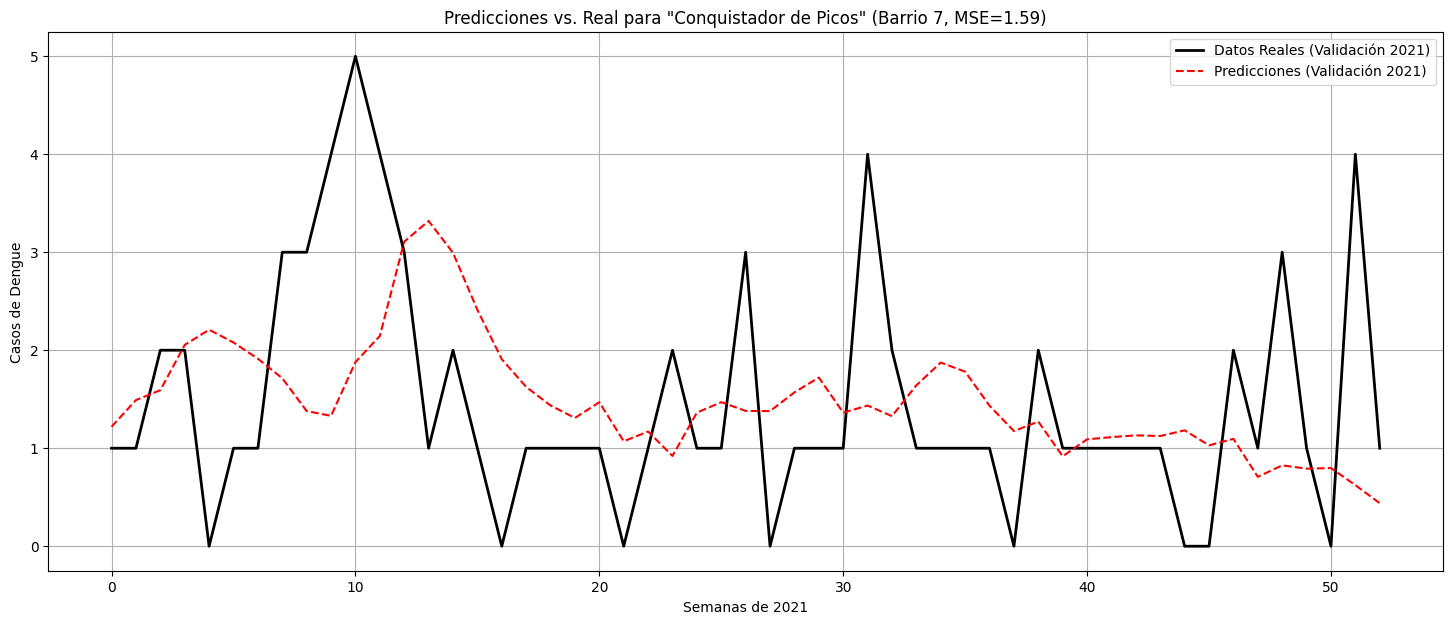

In [34]:
# --- Celda 7: Visualización de predicciones ---
barrio_ejemplo = 7
if barrio_ejemplo in validation_results:
    data = validation_results[barrio_ejemplo]
    mse_val = mean_squared_error(data['real'], data['preds'])
    
    plt.figure(figsize=(18, 7))
    plt.plot(data['real'], label='Datos Reales (Validación 2021)', color='black', linewidth=2)
    plt.plot(data['preds'], label=f'Predicciones (Validación 2021)', color='red', linestyle='--')
    plt.title(f'Predicciones vs. Real para "Conquistador de Picos" (Barrio {barrio_ejemplo}, MSE={mse_val:.2f})')
    plt.xlabel('Semanas de 2021'), plt.ylabel('Casos de Dengue'), plt.legend(), plt.grid(True)
    plt.show()

En esta gráfica observamos que las predicciones logran seguir de manera coherente la tendencia general de los casos reales de dengue a lo largo del año. Aunque el modelo tiende a suavizar los picos más pronunciados, logra capturar bien las transiciones entre periodos de mayor y menor incidencia, sin generar ruido excesivo ni oscilaciones artificiales. 

El MSE obtenido (1.59) respalda este buen rendimiento, mostrando que el error promedio es bajo y que el modelo se adapta bien a la dinámica del barrio.

# Visualización Curva de Loss

Generamos la visualización de la curva de pérdida (loss) del modelo durante el entrenamiento para un barrio específico, en este caso el barrio 3. La visualización permite analizar cómo evoluciona el error del modelo en cada época, tanto sobre los datos de entrenamiento como de validación.

Esta gráfica nos permite evaluar si el modelo está aprendiendo de manera estable, identificar posibles signos de sobreajuste (overfitting), y confirmar que la pérdida en validación converge junto con la de entrenamiento, lo cual es un buen indicador del proceso de generalización.

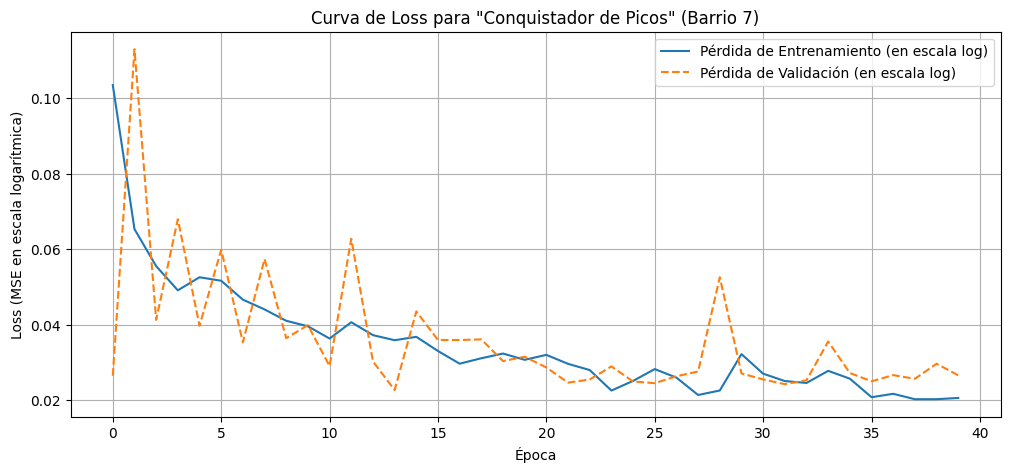

In [35]:
# --- Celda 8: Visualización Curva de Loss ---
barrio_ejemplo = 7
if barrio_ejemplo in validation_results:
    history_to_plot = validation_results[barrio_ejemplo]['history']
    
    plt.figure(figsize=(12, 5))
    plt.plot(history_to_plot['loss'], label='Pérdida de Entrenamiento (en escala log)')
    plt.plot(history_to_plot['val_loss'], label='Pérdida de Validación (en escala log)', linestyle='--')
    plt.title(f'Curva de Loss para "Conquistador de Picos" (Barrio {barrio_ejemplo})')
    plt.xlabel('Época'), plt.ylabel('Loss (MSE en escala logarítmica)'), plt.legend(), plt.grid(True)
    plt.show()

En esta gráfica, observamos que tanto la pérdida de entrenamiento como la de validación muestran una trayectoria descendente y estable, sin señales de sobreajuste. A medida que avanzan las épocas, ambas curvas convergen hacia valores bajos y similares, lo cual indica que el modelo aprende de manera progresiva y generaliza correctamente en datos no vistos. Las fluctuaciones iniciales en la validación son esperadas, pero se estabilizan rápidamente.

## **Generar Submissions**

En esta etapa ejecutamos el entrenamiento final del modelo para cada barrio, utilizando el total de información histórica disponible hasta el año 2021.

Para cada uno, aplicamos un pipeline específico: filtramos los datos por barrio, escalamos las variables explicativas, generamos las secuencias temporales requeridas según la ventana definida (LOOK_BACK = 12), y entrenamos un modelo especializado con la arquitectura seleccionada (CNN-LSTM).

Una vez entrenado, usamos el modelo para predecir los casos de dengue correspondientes al año 2022. Finalmente, revertimos las transformaciones aplicadas durante el preprocesamiento —como el escalamiento y la transformación logarítmica— para recuperar los valores en la escala original de los datos. Estas predicciones se almacenan de forma estructurada y lista para consolidarse en el archivo de salida final.

In [9]:
# --- Celda 9: Generar Submission Final ---
print("\n--- Entrenamiento Final con datos filtrados y transformados ---")
final_predictions = {}
for i, barrio_id in enumerate(barrios):
    print(f"\r  -> Entrenando especialista final para Barrio {i+1}/{len(barrios)}", end="")
    
    df_barrio = df_transformed[df_transformed['id_bar'] == barrio_id].copy().reset_index(drop=True)
    train_df = df_barrio[df_barrio['anio'] < 2022]
    test_df = df_barrio[df_barrio['anio'] == 2022]

    if len(train_df) < LOOK_BACK_GANADOR + 5:
        preds_real = np.zeros(len(test_df))
    else:
        features_to_use = [c for c in df_transformed.columns if c not in ['id', 'id_bar', 'anio', 'semana', 'dengue']]
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_df[features_to_use])
        dengue_log_col_index = features_to_use.index('dengue_log')
        
        X_train, y_train = [], []
        for j in range(LOOK_BACK_GANADOR, len(train_scaled)):
            X_train.append(train_scaled[j-LOOK_BACK_GANADOR:j])
            y_train.append(train_scaled[j, dengue_log_col_index])
        X_train, y_train = np.array(X_train), np.array(y_train)

        model = build_champion_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, verbose=0)
        
        full_scaled = scaler.transform(df_barrio[features_to_use])
        test_sequences = []
        for idx in test_df.index:
            test_sequences.append(full_scaled[idx-LOOK_BACK_GANADOR:idx])
        
        preds_scaled = model.predict(np.array(test_sequences), verbose=0)
        
        dummy_preds = np.zeros((len(preds_scaled), len(features_to_use)))
        dummy_preds[:, dengue_log_col_index] = preds_scaled.flatten()
        preds_log = scaler.inverse_transform(dummy_preds)[:, dengue_log_col_index]
        preds_real = np.expm1(preds_log) # Invertir el logaritmo
        
    for k, pred in enumerate(preds_real.flatten()):
        submission_id = test_df['id'].iloc[k]
        final_predictions[submission_id] = pred
print("\nEntrenamiento final completado.")


--- Entrenamiento Final con datos filtrados y transformados ---
  -> Entrenando especialista final para Barrio 10/10
Entrenamiento final completado.


## **Guardar Resultados**

En esta etapa final, consolidamos todas las predicciones en un único DataFrame de submission. Aplicamos un postprocesamiento final para redondear los valores a dos decimales, eliminar posibles negativos y asegurar la limpieza del resultado. Finalmente, guardamos el archivo CSV con un timestamp único, dejando el modelo listo para ser evaluado o compartido.

In [ ]:
# --- Celda 10: Guardar Submission ---
df_submission_final = df_test_original[['id']].copy()
df_submission_final['dengue'] = df_submission_final['id'].map(final_predictions)
df_submission_final['dengue'] = df_submission_final['dengue'].clip(lower=0).fillna(0)
df_submission_final['dengue'] = df_submission_final['dengue'].round(2)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_filename = f"submission_CNN_LSTM_{timestamp}.csv"
df_submission_final.to_csv(submission_filename, index=False)

print(f"\nArchivo final '{submission_filename}' generado con éxito.")
print("Primeras 5 filas de la predicción:")
print(df_submission_final.head())


Archivo final 'submission_ConquistadorDePicos_20250627_001033.csv' generado con éxito.
Primeras 5 filas de la predicción:
             id  dengue
3680  4_2022_01    0.51
3681  5_2022_01    0.53
3682  3_2022_01    0.73
3683  8_2022_01    0.27
3684  9_2022_01    0.20
